In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
data = pd.read_table('musk/clean2.data', header=None, delimiter=',')

In [3]:
names = np.unique(data[0])

def get_train_test_data(train_idx):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for name in names[train_idx]:
        idx = np.in1d(data[0], name)
        X_train.append(data.values[idx, 2:-1])
        y_train.append(max(data.values[idx, -1:]))

    for name in names[~train_idx]:
        idx = np.in1d(data[0], name)
        X_test.append(data.values[idx, 2:-1])
        y_test.append(max(data.values[idx, -1:]))
        
    return X_train, X_test, y_train, y_test

In [4]:
train_idx = np.array([True] * 80 + [False] * 22)
np.random.seed(10)
np.random.shuffle(train_idx)
X_train, X_test, y_train, y_test = get_train_test_data(train_idx)

In [5]:
# Network Parameters
n_input = 166 # input data size
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 128 # 2nd layer number of features
n_hidden_3 = 32 # 3nd layer number of features
n_hidden_4 = 1 # 4nd layer number of features

# tf Graph input
x = tf.placeholder("float", [None, None, n_input])
y = tf.placeholder("float", [None])

In [6]:
def MILNeuralNetwork(multilayer_perceptron, learning_rate = 1e-03, training_epochs = 10,
                     display_step = 1):
    
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
        'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'b4': tf.Variable(tf.random_normal([n_hidden_4]))
    }

    # Construct model
    pred = multilayer_perceptron(x, weights, biases)

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)

        accuracy_history = np.zeros(training_epochs)
        order = np.arange(len(y_train))
        # Training cycle
        for epoch in range(training_epochs):
            
            avg_cost = 0
            np.random.shuffle(order)
            for i in order:
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: X_train[i][np.newaxis], y: y_train[i]})

                # Compute average loss
                avg_cost += c / len(y_train)
                # Display logs per epoch step
#             if epoch % display_step == 0:
#                 print "Epoch:", '%04d' % (epoch+1), "cost=", \
#                     "{:.9f}".format(avg_cost)

            # Test model
            # Calculate accuracy
            correct_prediction = tf.equal(tf.cast(tf.greater(pred, 0.5), 'float'), y)
            # Calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            for i in range(len(y_test)):
                accuracy_history[epoch] += accuracy.eval({x: X_test[i][np.newaxis], y: y_test[i]}) / len(y_test)
        
        #print "Optimization Finished!"
        print "Accuracy:", accuracy_history[-1]
        
        return accuracy_history

In [7]:
def perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.tensordot(x, weights['h1'], axes=[[2],[0]]), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.tensordot(layer_1, weights['h2'], axes=[[2],[0]]), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.tensordot(layer_2, weights['h3'], axes=[[2],[0]]), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)
    
    # Hidden layer with RELU activation
    layer_4 = tf.add(tf.tensordot(layer_3, weights['h4'], axes=[[2],[0]]), biases['b4'])
    layer_4 = tf.nn.sigmoid(layer_4)
    
    # Output layer
    out_layer = tf.reduce_max(layer_4, reduction_indices=1)
    
    return out_layer

In [8]:
accuracy = MILNeuralNetwork(multilayer_perceptron=perceptron, training_epochs=100)

Accuracy: 0.681818181818


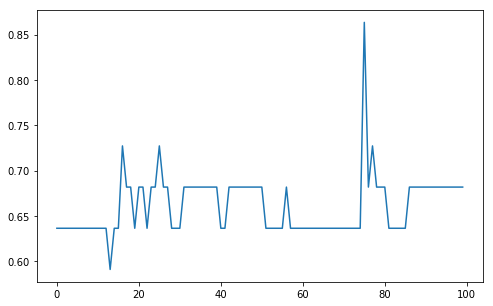

In [9]:
plt.figure(figsize=(8,5))
plt.plot(accuracy)
plt.show()

Accuracy: 0.409090909091
Accuracy: 0.454545454545
Accuracy: 0.727272727273
Accuracy: 0.636363636364
Accuracy: 0.636363636364
Accuracy: 0.636363636364
Accuracy: 0.363636363636


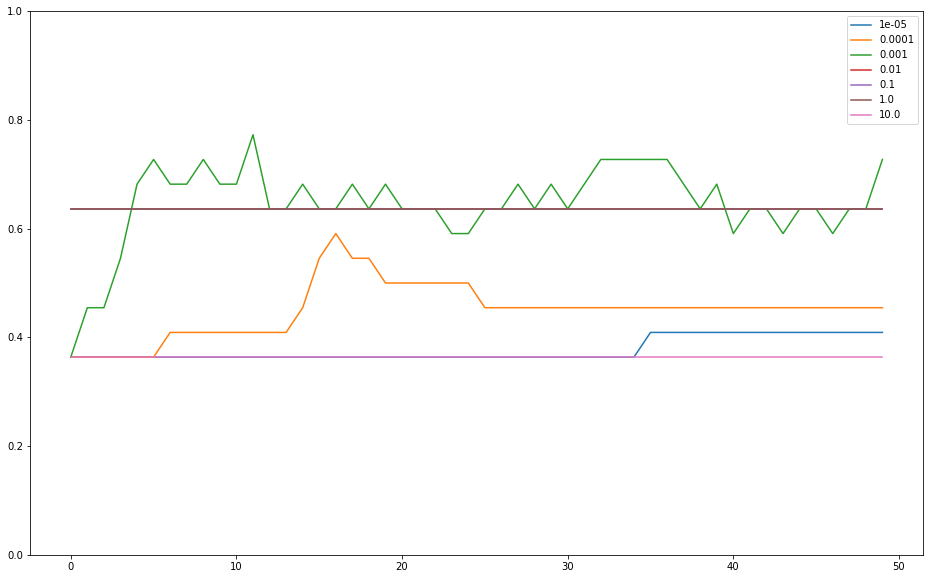

In [10]:
accuracies = []
plt.figure(figsize=(16,10))
for lr in np.logspace(-5, 1, 7):
    accuracies.append(MILNeuralNetwork(multilayer_perceptron=perceptron,
                                       training_epochs=50, learning_rate=lr))
    plt.plot(accuracies[-1], label=lr)

plt.legend(loc='best')
plt.ylim([0.0, 1.0])
plt.show()

In [11]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
np.random.seed(1)

accuracies = []
for train_idx, test_idx in kf.split(names):

    train_names = names[train_idx]
    train_idx = np.in1d(names, train_names) 
    X_train, X_test, y_train, y_test = get_train_test_data(train_idx)
    accuracies.append(MILNeuralNetwork(multilayer_perceptron=perceptron, training_epochs=75,
                                      learning_rate=1e-03))
    
#print np.round(accuracies, decimals=2)

Accuracy: 0.909090909091
Accuracy: 0.909090909091
Accuracy: 0.6
Accuracy: 0.8
Accuracy: 0.8
Accuracy: 0.4
Accuracy: 0.8
Accuracy: 0.7
Accuracy: 0.7
Accuracy: 0.8


In [12]:
print '10-Fold accuracy: {0}+-{1}'.format(np.mean(np.array(accuracies)[:,-1]),
                                          np.std(np.array(accuracies)[:,-1]))

10-Fold accuracy: 0.741818181818+-0.144896657388


## Padding NN

To evade learning with batch_size=1, let's use tensor of shape (n_bags, max_n_instances, n_features), where if number of instances for some bag is less then max_n_instances, we pad the rest part of our tensor with 0.

In [13]:
max_n_instances = 1044 # maximal number of instances for bag
n_features = 166
n_bags = 102

X_data = np.zeros((n_bags, max_n_instances, n_features))
y_data = np.zeros(n_bags)
names = np.unique(data[0])

for i, name in enumerate(names):
    idx = np.in1d(data[0], name)
    temp = np.array(data.values[idx, 2:-1])
    temp.resize((max_n_instances, n_features))
    X_data[i] = temp
    y_data[i] = np.max(data.values[idx, -1:])

In [14]:
np.random.seed(1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

In [15]:
# Network Parameters
n_input = n_features # input data size
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 128 # 2nd layer number of features
n_hidden_3 = 32 # 3nd layer number of features
n_hidden_4 = 1 # 4nd layer number of features

# tf Graph input
x = tf.placeholder("float", [None, max_n_instances, n_input])
y = tf.placeholder("float", [None])

In [16]:
def perceptron_pad(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.tensordot(x, weights['h1'], axes=[[2],[0]]), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.tensordot(layer_1, weights['h2'], axes=[[2],[0]]), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.tensordot(layer_2, weights['h3'], axes=[[2],[0]]), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)
    
    # Hidden layer with RELU activation
    layer_4 = tf.add(tf.tensordot(layer_3, weights['h4'], axes=[[2],[0]]), biases['b4'])
    layer_4 = tf.nn.sigmoid(layer_4)
    mask = tf.sign(tf.reduce_max(tf.abs(x), reduction_indices=2))
    layer_4 = tf.multiply(tf.reduce_max(layer_4, reduction_indices=2), mask)

    # Output layer
    out_layer = tf.reduce_max(layer_4, reduction_indices=1)

    return out_layer

In [17]:
def PadMILNeuralNetwork(multilayer_perceptron, learning_rate = 1e-03, training_epochs = 10,
                        display_step = 1):
    
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
        'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'b4': tf.Variable(tf.random_normal([n_hidden_4]))
    }

    # Construct model
    pred = multilayer_perceptron(x, weights, biases)

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)

        accuracy_history = np.zeros(training_epochs)
        # Training cycle
        for epoch in range(training_epochs):
            
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: X_train, y: y_train})

            # Display logs per epoch step
#             if epoch % display_step == 0:
#                 print "Epoch:", '%04d' % (epoch+1), "cost=", \
#                     "{:.9f}".format(c)

            # Test model
            # Calculate accuracy
            correct_prediction = tf.equal(tf.cast(tf.greater(pred, 0.5), 'float'), y)
            # Calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            accuracy_history[epoch] += accuracy.eval({x: X_test, y: y_test})
        
        #print pred.eval({x: X_test, y: y_test})
        #print "Optimization Finished!"
        print "Accuracy:", accuracy_history[-1]
        
        return accuracy_history

In [18]:
accuracy = PadMILNeuralNetwork(multilayer_perceptron=perceptron_pad, training_epochs=100)

Accuracy: 0.615384638309


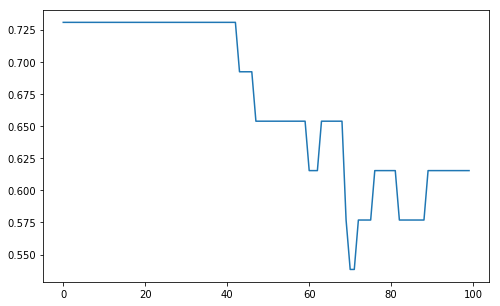

In [19]:
plt.figure(figsize=(8,5))
plt.plot(accuracy)
plt.show()

Accuracy: 0.269230782986
Accuracy: 0.269230782986
Accuracy: 0.461538463831
Accuracy: 0.692307710648
Accuracy: 0.730769217014
Accuracy: 0.730769217014
Accuracy: 0.730769217014


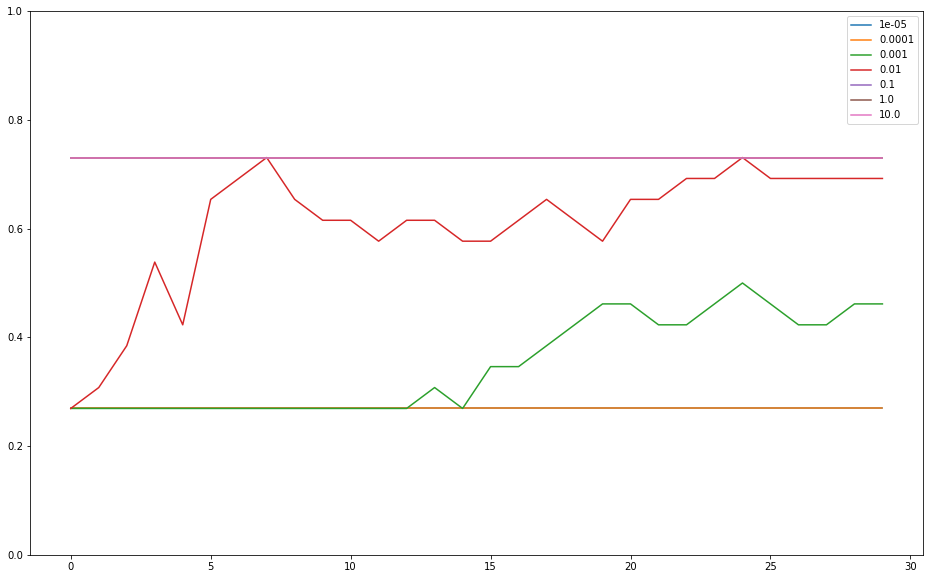

In [20]:
accuracies = []
plt.figure(figsize=(16,10))
for lr in np.logspace(-5, 1, 7):
    accuracies.append(PadMILNeuralNetwork(multilayer_perceptron=perceptron_pad,
                                       training_epochs=30, learning_rate=lr))
    plt.plot(accuracies[-1], label=lr)

plt.legend(loc='best')
plt.ylim([0.0, 1.0])
plt.show()

In [23]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
np.random.seed(1)

accuracies = []
for train_idx, test_idx in kf.split(X_data, y_data):

    X_train = X_data[train_idx]
    X_test = X_data[test_idx]
    y_train = y_data[train_idx]
    y_test = y_data[test_idx]
    accuracies.append(PadMILNeuralNetwork(multilayer_perceptron=perceptron_pad, training_epochs=30,
                                          learning_rate=5e-03))

print '10-Fold accuracy: {0}+-{1}'.format(np.mean(np.array(accuracies)[:,-1]),
                                          np.std(np.array(accuracies)[:,-1]))

Accuracy: 0.909090936184
Accuracy: 0.636363625526
Accuracy: 0.600000023842
Accuracy: 0.699999988079
Accuracy: 0.800000011921
Accuracy: 0.5
Accuracy: 0.699999988079
Accuracy: 0.699999988079
Accuracy: 0.600000023842
Accuracy: 0.40000000596
10-Fold accuracy: 0.654545459151+-0.136787223155


In [ ]:
# accuracy = PadMILNeuralNetwork(multilayer_perceptron=perceptron_pad, training_epochs=1000)

# plt.figure(figsize=(8,5))
# plt.plot(accuracy)
# plt.ylim([0.0, 1.0])
# plt.show()

## References

[1] https://arxiv.org/pdf/1610.02501.pdf

[2] http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/techrep02.pdf

[3] https://arxiv.org/pdf/1609.07257.pdf

[4] https://danijar.com/variable-sequence-lengths-in-tensorflow/